In [1]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('Dataset.csv', parse_dates=['datetime'])

# Set datetime as index
df.set_index('datetime', inplace=True)

# Optional: print shape & quick info
print(df.shape)
print(df.head())
print(df.info())


(17472, 108)
                     meteorolgicas_em_03_02_gii  meteorolgicas_em_08_01_gii  \
datetime                                                                      
2024-10-01 00:00:00                         0.0                         0.0   
2024-10-01 00:15:00                         0.0                         0.0   
2024-10-01 00:30:00                         0.0                         0.0   
2024-10-01 00:45:00                         0.0                         0.0   
2024-10-01 01:00:00                         0.0                         0.0   

                     meteorolgicas_em_03_02_ghi  meteorolgicas_em_08_01_ghi  \
datetime                                                                      
2024-10-01 00:00:00                         0.0                         0.0   
2024-10-01 00:15:00                         0.0                         0.0   
2024-10-01 00:30:00                         0.0                         0.0   
2024-10-01 00:45:00                   

In [3]:
# Step 2.1: Clip non-negative metrics to >=0
non_negative_patterns = [
    'meteorolgicas_',  # for irradiance
    'celulas_',        # for irradiance from cells
    'inversores_',     # for inverter power and dc power
    'ppc_p_tot', 'ttr_potenciaproducible'
]

# Find all matching columns that must be non-negative
non_negative_cols = [col for col in df.columns if any(p in col for p in non_negative_patterns)]

# Apply clip to each column
df[non_negative_cols] = df[non_negative_cols].clip(lower=0)

print(f"✅ Clipped {len(non_negative_cols)} columns to be >=0")


✅ Clipped 99 columns to be >=0


In [5]:
humidity_cols = [col for col in df.columns if '_h_r' in col]
df[humidity_cols] = df[humidity_cols].clip(lower=0, upper=100)

print(f"✅ Clipped humidity columns to [0, 100]: {humidity_cols}")


✅ Clipped humidity columns to [0, 100]: ['meteorolgicas_em_03_02_h_r', 'meteorolgicas_em_08_01_h_r']


In [7]:
# Ambient temperatures
t_amb_cols = [col for col in df.columns if '_t_amb' in col]
for col in t_amb_cols:
    df.loc[(df[col] < -20) | (df[col] > 50), col] = np.nan

# Module temperatures
t_mod_cols = [col for col in df.columns if '_t_mod' in col]
for col in t_mod_cols:
    df.loc[(df[col] < -20) | (df[col] > 90), col] = np.nan

# Data logger temperatures
t_dlogger_cols = [col for col in df.columns if '_t_dlogger' in col]
for col in t_dlogger_cols:
    df.loc[(df[col] < -20) | (df[col] > 50), col] = np.nan

print(f"✅ Cleaned temperature columns (ambient: {t_amb_cols}, module: {t_mod_cols}, datalogger: {t_dlogger_cols})")


✅ Cleaned temperature columns (ambient: ['meteorolgicas_em_03_02_t_amb', 'meteorolgicas_em_08_01_t_amb', 'celulas_ctin08_cc_08_2_t_amb', 'celulas_ctin03_cc_03_1_t_amb', 'celulas_ctin08_cc_08_1_t_amb', 'celulas_ctin03_cc_03_2_t_amb'], module: ['celulas_ctin03_cc_03_1_t_mod', 'celulas_ctin08_cc_08_2_t_mod', 'celulas_ctin03_cc_03_2_t_mod', 'celulas_ctin08_cc_08_1_t_mod'], datalogger: ['meteorolgicas_em_03_02_t_dlogger', 'meteorolgicas_em_08_01_t_dlogger'])


In [9]:
# Wind direction
wd_cols = [col for col in df.columns if '_wd' in col]
for col in wd_cols:
    df.loc[(df[col] < 0) | (df[col] > 360), col] = np.nan

# Tracker angles
tracker_angle_cols = [col for col in df.columns if '_pos_ang' in col or '_pos_obj' in col]
for col in tracker_angle_cols:
    df.loc[(df[col] < -60) | (df[col] > 60), col] = np.nan

print(f"✅ Cleaned wind direction and tracker angle columns")


✅ Cleaned wind direction and tracker angle columns


In [13]:
# Step 3: Create day/night mask
# ppc_p_tot might be in kW or MW – adjust threshold if needed (e.g., >0.01)
is_daytime = df['ppc_p_tot'] > 0.01

# Add as a new column for clarity (optional)
df['is_daytime'] = is_daytime

# Check result
print(f"✅ Number of daytime rows: {is_daytime.sum()}")
print(f"✅ Number of nighttime rows: {(~is_daytime).sum()}")


✅ Number of daytime rows: 7506
✅ Number of nighttime rows: 9966


In [21]:
inversores_cols = [
    # String 8
    'inversores_ctin03_strings_string8_pv_v',
    'inversores_ctin03_strings_string8_pv_i9',
    'inversores_ctin03_strings_string8_pv_i13',
    'inversores_ctin03_strings_string8_pv_i1',
    'inversores_ctin03_strings_string8_pv_i6',
    'inversores_ctin03_strings_string8_pv_i4',
    'inversores_ctin03_strings_string8_pv_i11',
    'inversores_ctin03_strings_string8_pv_i10',
    'inversores_ctin03_strings_string8_pv_i2',
    'inversores_ctin03_strings_string8_pv_i5',
    'inversores_ctin03_strings_string8_pv_i7',
    'inversores_ctin03_strings_string8_pv_i12',
    'inversores_ctin03_strings_string8_pv_i3',
    'inversores_ctin03_strings_string8_pv_i8',

    # String 10
    'inversores_ctin03_strings_string10_pv_i9',
    'inversores_ctin03_strings_string10_pv_i7',
    'inversores_ctin03_strings_string10_pv_i4',
    'inversores_ctin03_strings_string10_pv_i12',
    'inversores_ctin03_strings_string10_pv_i8',
    'inversores_ctin03_strings_string10_pv_i13',
    'inversores_ctin03_strings_string10_pv_i10',
    'inversores_ctin03_strings_string10_pv_i6',
    'inversores_ctin03_strings_string10_pv_i11',
    'inversores_ctin03_strings_string10_pv_i5',
    'inversores_ctin03_strings_string10_pv_i1',
    'inversores_ctin03_strings_string10_pv_i3',
    'inversores_ctin03_strings_string10_pv_i2',
    'inversores_ctin03_strings_string10_pv_v',

    # String 9 (ctin08)
    'inversores_ctin08_strings_string9_pv_i12',
    'inversores_ctin08_strings_string9_pv_i13',
    'inversores_ctin08_strings_string9_pv_i1',
    'inversores_ctin08_strings_string9_pv_i7',
    'inversores_ctin08_strings_string9_pv_i8',
    'inversores_ctin08_strings_string9_pv_i6',
    'inversores_ctin08_strings_string9_pv_i10',
    'inversores_ctin08_strings_string9_pv_i9',
    'inversores_ctin08_strings_string9_pv_i11',
    'inversores_ctin08_strings_string9_pv_i4',
    'inversores_ctin08_strings_string9_pv_i5',
    'inversores_ctin08_strings_string9_pv_i2',
    'inversores_ctin08_strings_string9_pv_i3',
    'inversores_ctin08_strings_string9_pv_v',

    # String 12
    'inversores_ctin08_strings_string12_pv_i4',
    'inversores_ctin08_strings_string12_pv_i1',
    'inversores_ctin08_strings_string12_pv_i5',
    'inversores_ctin08_strings_string12_pv_i7',
    'inversores_ctin08_strings_string12_pv_i3',
    'inversores_ctin08_strings_string12_pv_i6',
    'inversores_ctin08_strings_string12_pv_i2',
    'inversores_ctin08_strings_string12_pv_i8',
    'inversores_ctin08_strings_string12_pv_i9',
    'inversores_ctin08_strings_string12_pv_i10',
    'inversores_ctin08_strings_string12_pv_v',

    # Power and energy
    'inversores_ctin08_inv_08_08_p',
    'inversores_ctin03_inv_03_03_p',
    'inversores_ctin03_inv_03_03_p_dc',
    'inversores_ctin08_inv_08_08_p_dc',
    'inversores_ctin03_inv_03_03_eact_tot',
    'inversores_ctin08_inv_08_08_eact_tot'
]

In [36]:
# Combine your lists: irradiance, power, current/voltage
irradiance_cols = [
    'meteorolgicas_em_03_02_gii',
    'meteorolgicas_em_08_01_gii',
    'meteorolgicas_em_03_02_ghi',
    'meteorolgicas_em_08_01_ghi',
    'meteorolgicas_em_08_01_gii_rear',
    'meteorolgicas_em_03_02_gii_rear',
    'celulas_ctin08_cc_08_1_ir_cel_1',
    'celulas_ctin08_cc_08_2_ir_cel_1',
    'celulas_ctin03_cc_03_1_ir_cel_1',
    'celulas_ctin03_cc_03_2_ir_cel_1',
    'celulas_ctin08_cc_08_2_ir_cel_2',
    'celulas_ctin03_cc_03_2_ir_cel_2',
    'celulas_ctin03_cc_03_1_ir_cel_2',
    'celulas_ctin08_cc_08_1_ir_cel_2'
]

power_cols = [
    'inversores_ctin08_inv_08_08_p',
    'inversores_ctin03_inv_03_03_p',
    'inversores_ctin03_inv_03_03_p_dc',
    'inversores_ctin08_inv_08_08_p_dc',
    'ppc_consig_p',
    'ppc_p_tot',
    'ttr_potenciaproducible'
]

current_voltage_cols = [
    'inversores_ctin03_strings_string8_pv_v',
    'inversores_ctin03_strings_string10_pv_v',
    'inversores_ctin08_strings_string9_pv_v',
    'inversores_ctin08_strings_string12_pv_v'
] + [col for col in inversores_cols if '_pv_i' in col]  # add all current columns

# Combine all
cols_to_impute = irradiance_cols + power_cols + current_voltage_cols

print(f"🧩 Using explicit irradiance cols: {irradiance_cols}")
print(f"🧩 Using explicit power cols: {power_cols}")
print(f"🧩 Using explicit current/voltage cols: {current_voltage_cols}")

# Nighttime: fill NaNs with 0
df.loc[~df['is_daytime'], cols_to_impute] = df.loc[~df['is_daytime'], cols_to_impute].fillna(0)

# Daytime: linear interpolation
df.loc[df['is_daytime'], cols_to_impute] = df.loc[df['is_daytime'], cols_to_impute].interpolate(method='linear')

print(f"✅ Filled NaNs: zero at night, interpolated during day for irradiance, power, current, voltage")


🧩 Using explicit irradiance cols: ['meteorolgicas_em_03_02_gii', 'meteorolgicas_em_08_01_gii', 'meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_08_01_ghi', 'meteorolgicas_em_08_01_gii_rear', 'meteorolgicas_em_03_02_gii_rear', 'celulas_ctin08_cc_08_1_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_1', 'celulas_ctin03_cc_03_1_ir_cel_1', 'celulas_ctin03_cc_03_2_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_2', 'celulas_ctin03_cc_03_2_ir_cel_2', 'celulas_ctin03_cc_03_1_ir_cel_2', 'celulas_ctin08_cc_08_1_ir_cel_2']
🧩 Using explicit power cols: ['inversores_ctin08_inv_08_08_p', 'inversores_ctin03_inv_03_03_p', 'inversores_ctin03_inv_03_03_p_dc', 'inversores_ctin08_inv_08_08_p_dc', 'ppc_consig_p', 'ppc_p_tot', 'ttr_potenciaproducible']
🧩 Using explicit current/voltage cols: ['inversores_ctin03_strings_string8_pv_v', 'inversores_ctin03_strings_string10_pv_v', 'inversores_ctin08_strings_string9_pv_v', 'inversores_ctin08_strings_string12_pv_v', 'inversores_ctin03_strings_string8_pv_i9', 'inversores_ctin03_




Checking-----------------------------------------------------------------------------------------------------------------------------------------------




In [31]:
num_columns = len(df.columns)
print(f"✅ Number of columns in DataFrame: {num_columns}")


✅ Number of columns in DataFrame: 109


In [27]:
# Check duplicate column names
duplicates = df.columns[df.columns.duplicated()].unique()
print(f"🔍 Duplicate columns: {duplicates}")


🔍 Duplicate columns: Index(['inversores_ctin03_strings_string8_pv_v',
       'inversores_ctin03_strings_string8_pv_i9',
       'inversores_ctin03_strings_string8_pv_i13',
       'inversores_ctin03_strings_string8_pv_i1',
       'inversores_ctin03_strings_string8_pv_i6',
       'inversores_ctin03_strings_string8_pv_i4',
       'inversores_ctin03_strings_string8_pv_i11',
       'inversores_ctin03_strings_string8_pv_i10',
       'inversores_ctin03_strings_string8_pv_i2',
       'inversores_ctin03_strings_string8_pv_i5',
       'inversores_ctin03_strings_string8_pv_i7',
       'inversores_ctin03_strings_string8_pv_i12',
       'inversores_ctin03_strings_string8_pv_i3',
       'inversores_ctin03_strings_string8_pv_i8',
       'inversores_ctin03_strings_string10_pv_i9',
       'inversores_ctin03_strings_string10_pv_i7',
       'inversores_ctin03_strings_string10_pv_i4',
       'inversores_ctin03_strings_string10_pv_i12',
       'inversores_ctin03_strings_string10_pv_i8',
       'inversores_c

In [29]:
# Remove duplicate columns, keep the first occurrence
df = df.loc[:, ~df.columns.duplicated()]
print("✅ Removed duplicate columns; df now has unique columns only")


✅ Removed duplicate columns; df now has unique columns only


In [33]:
df

,meteorolgicas_em_03_02_gii,meteorolgicas_em_08_01_gii,meteorolgicas_em_03_02_ghi,meteorolgicas_em_08_01_ghi,meteorolgicas_em_08_01_gii_rear,meteorolgicas_em_03_02_gii_rear,meteorolgicas_em_03_02_desviacin_incidente,meteorolgicas_em_08_01_desviacin_incidente,meteorolgicas_em_03_02_t_amb,meteorolgicas_em_08_01_t_amb,...,seguidores_ct08_gcu081_t0808029_workingmode,seguidores_ct03_gcu031_t0308035_pos_ang,seguidores_ct03_gcu031_t0308035_pos_obj,seguidores_ct03_gcu031_t0308035_workingmode,ppc_consig_p,ppc_p_tot,ppc_eact_export,ttr_potenciaproducible,ppc_eact_imp,is_daytime
datetime,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.034977,18.220884,...,NaN,0.2,0.0,NaN,43.485001,0.0,NaN,0.0,NaN,False
2024-10-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.737464,18.397779,...,NaN,0.2,0.0,NaN,43.485001,0.0,0.023,0.0,0.0,False
2024-10-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.681954,18.268321,...,NaN,0.2,0.0,NaN,43.485001,0.0,0.022,0.0,0.0,False
2024-10-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.661525,18.112144,...,NaN,0.3,0.0,NaN,43.485001,0.0,0.022,0.0,0.0,False
2024-10-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.596177,18.064552,...,NaN,0.3,0.0,NaN,43.485001,0.0,0.023,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.088258,15.146526,...,NaN,-10.1,-10.0,NaN,43.485001,0.0,0.021,0.0,0.0,False
2025-03-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.941294,14.764474,...,NaN,-10.1,-10.0,NaN,43.485001,0.0,0.020,0.0,0.0,False
2025-03-31 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.408036,14.624276,...,NaN,-10.1,-10.0,NaN,43.485001,0.0,0.022,0.0,0.0,False





check completed---------------------------------------------------------------------------------------------------------------------------------------





In [38]:
# Step 4.2: Temperature imputation

# Identify temperature columns
temp_cols = [col for col in df.columns if '_t_amb' in col or '_t_mod' in col or '_t_dlogger' in col]

print(f"🌡 Found temperature columns: {temp_cols}")

# Apply linear interpolation
df[temp_cols] = df[temp_cols].interpolate(method='linear', limit_direction='both')

print("✅ Filled NaNs in temperature columns using linear interpolation")


🌡 Found temperature columns: ['meteorolgicas_em_03_02_t_amb', 'meteorolgicas_em_08_01_t_amb', 'meteorolgicas_em_03_02_t_dlogger', 'meteorolgicas_em_08_01_t_dlogger', 'celulas_ctin08_cc_08_2_t_amb', 'celulas_ctin03_cc_03_1_t_amb', 'celulas_ctin08_cc_08_1_t_amb', 'celulas_ctin03_cc_03_2_t_amb', 'celulas_ctin03_cc_03_1_t_mod', 'celulas_ctin08_cc_08_2_t_mod', 'celulas_ctin03_cc_03_2_t_mod', 'celulas_ctin08_cc_08_1_t_mod']
✅ Filled NaNs in temperature columns using linear interpolation


C:\Users\dell\AppData\Local\Temp\ipykernel_8252\3822801418.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp_cols] = df[temp_cols].interpolate(method='linear', limit_direction='both')


In [40]:
# Step 4.3: Impute wind speed, humidity, and datalogger temperature

# Identify relevant columns
wind_cols = [col for col in df.columns if '_ws' in col]
humidity_cols = [col for col in df.columns if '_h_r' in col]
# You already did datalogger temperature in temp_cols, so we can reuse it
# But we can double-check to make sure

print(f"💨 Found wind speed columns: {wind_cols}")
print(f"💧 Found humidity columns: {humidity_cols}")

# Apply linear interpolation
df[wind_cols + humidity_cols] = df[wind_cols + humidity_cols].interpolate(method='linear', limit_direction='both')

print("✅ Filled NaNs in wind speed and humidity columns using linear interpolation")


💨 Found wind speed columns: ['meteorolgicas_em_08_01_ws', 'meteorolgicas_em_03_02_ws']
💧 Found humidity columns: ['meteorolgicas_em_03_02_h_r', 'meteorolgicas_em_08_01_h_r']
✅ Filled NaNs in wind speed and humidity columns using linear interpolation


C:\Users\dell\AppData\Local\Temp\ipykernel_8252\2141003248.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[wind_cols + humidity_cols] = df[wind_cols + humidity_cols].interpolate(method='linear', limit_direction='both')


In [42]:
# Step 4.4: Tracker data imputation

# Identify tracker columns (position and working mode)
tracker_cols = [col for col in df.columns if 'seguidores_' in col and ('pos_' in col or 'workingmode' in col)]

print(f"🧭 Found tracker columns: {tracker_cols}")

# Apply forward fill
df[tracker_cols] = df[tracker_cols].fillna(method='ffill')

print("✅ Filled NaNs in tracker position and working mode columns using forward fill")


🧭 Found tracker columns: ['seguidores_ct08_gcu081_t0808029_pos_obj', 'seguidores_ct08_gcu081_t0808029_pos_ang', 'seguidores_ct08_gcu081_t0808029_workingmode', 'seguidores_ct03_gcu031_t0308035_pos_ang', 'seguidores_ct03_gcu031_t0308035_pos_obj', 'seguidores_ct03_gcu031_t0308035_workingmode']
✅ Filled NaNs in tracker position and working mode columns using forward fill


C:\Users\dell\AppData\Local\Temp\ipykernel_8252\3592156949.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[tracker_cols] = df[tracker_cols].fillna(method='ffill')
C:\Users\dell\AppData\Local\Temp\ipykernel_8252\3592156949.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[tracker_cols] = df[tracker_cols].fillna(method='ffill')


In [44]:
# Step 5: Handle cumulative energy columns

# Identify cumulative energy columns
energy_cols = [col for col in df.columns if col.endswith('_eact_tot') or col in ['ppc_eact_export', 'ppc_eact_imp']]

print(f"⚡ Found cumulative energy columns: {energy_cols}")

for col in energy_cols:
    # Step 5.1: Compute interval energy
    interval_col = col + '_interval'
    df[interval_col] = df[col].diff()

    # Step 5.2: Handle resets: if diff is negative, assume it's a counter reset → set interval to value itself
    df.loc[df[interval_col] < 0, interval_col] = df.loc[df[interval_col] < 0, col]

    # Step 5.3: Impute missing interval energy
    # At night: zero; during day: interpolate
    df.loc[~df['is_daytime'], interval_col] = df.loc[~df['is_daytime'], interval_col].fillna(0)
    df.loc[df['is_daytime'], interval_col] = df.loc[df['is_daytime'], interval_col].interpolate(method='linear', limit_direction='both')

    # Step 5.4: Recompute cleaned cumulative energy
    cleaned_col = col + '_cleaned'
    df[cleaned_col] = df[interval_col].fillna(0).cumsum() + df[col].iloc[0]

    print(f"✅ Cleaned cumulative energy for: {col} → new column: {cleaned_col}")

print("🎉 Step 5 complete: cumulative energy cleaned and recalculated")


⚡ Found cumulative energy columns: ['inversores_ctin03_inv_03_03_eact_tot', 'inversores_ctin08_inv_08_08_eact_tot', 'ppc_eact_export', 'ppc_eact_imp']
✅ Cleaned cumulative energy for: inversores_ctin03_inv_03_03_eact_tot → new column: inversores_ctin03_inv_03_03_eact_tot_cleaned
✅ Cleaned cumulative energy for: inversores_ctin08_inv_08_08_eact_tot → new column: inversores_ctin08_inv_08_08_eact_tot_cleaned
✅ Cleaned cumulative energy for: ppc_eact_export → new column: ppc_eact_export_cleaned
✅ Cleaned cumulative energy for: ppc_eact_imp → new column: ppc_eact_imp_cleaned
🎉 Step 5 complete: cumulative energy cleaned and recalculated


C:\Users\dell\AppData\Local\Temp\ipykernel_8252\3431661336.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interval_col] = df[col].diff()
C:\Users\dell\AppData\Local\Temp\ipykernel_8252\3431661336.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[interval_col] = df[col].diff()
C:\Users\dell\AppData\Local\Temp\ipykernel_8252\3431661336.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

C:\Users\dell\AppData\Local\Temp\ipykernel_8252\711492249.py:30: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


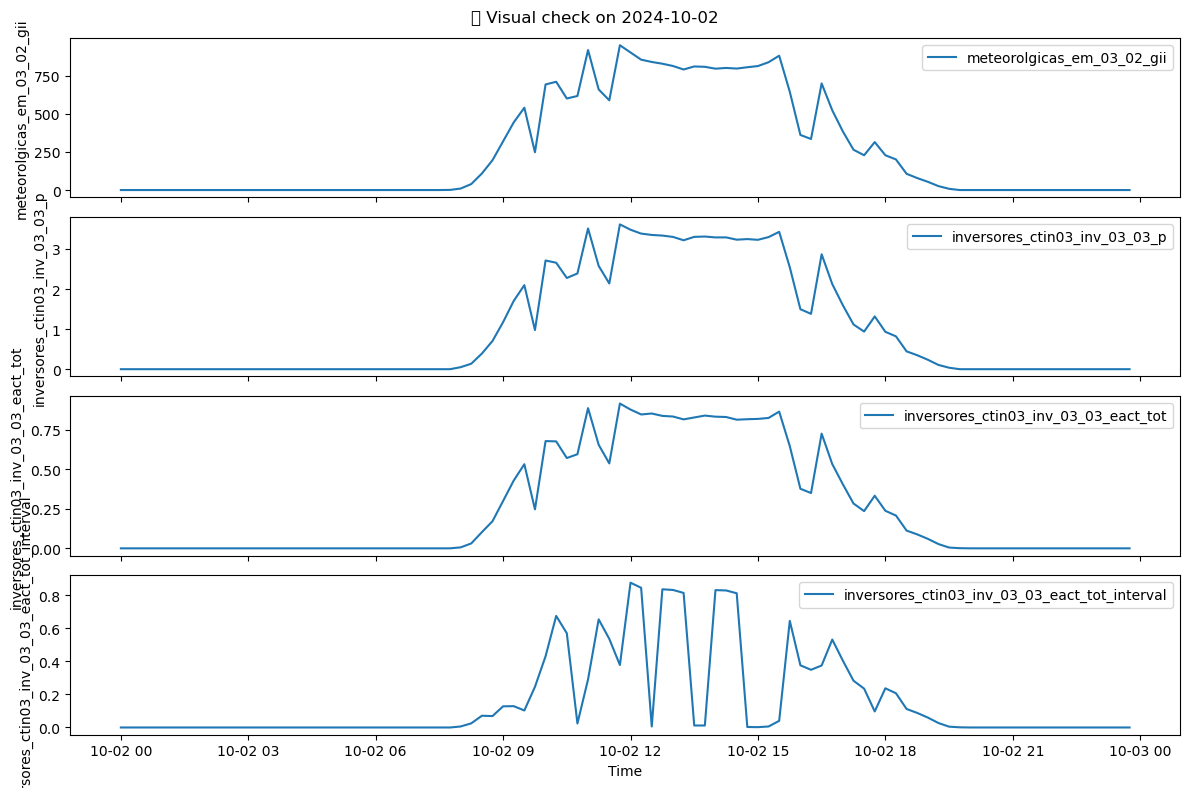

📊 Plots ready! Visually confirm cleaning looks correct.
💾 Saved cleaned data to: cleaned_dataset.csv


In [58]:
import matplotlib.pyplot as plt

# Pick a day to plot (change date if needed)
plot_date = '2024-10-02'


# Pick columns to visualize: one irradiance, one power, one cumulative energy
sample_cols = [
    'meteorolgicas_em_03_02_gii',
    'inversores_ctin03_inv_03_03_p',
    'inversores_ctin03_inv_03_03_eact_tot',
    # 'inversores_ctin03_inv_03_03_eact_tot_cleaned'  # cleaned cumulative
    'inversores_ctin03_inv_03_03_eact_tot_interval'

]

# Plot
fig, axs = plt.subplots(len(sample_cols), 1, figsize=(12, 8), sharex=True)

for i, col in enumerate(sample_cols):
    if col in df.columns:
        axs[i].plot(df.loc[plot_date].index, df.loc[plot_date, col], label=col)
        axs[i].set_ylabel(col)
        axs[i].legend()
    else:
        axs[i].set_visible(False)

plt.xlabel('Time')
plt.suptitle(f'✅ Visual check on {plot_date}')
plt.tight_layout()
plt.show()

print("📊 Plots ready! Visually confirm cleaning looks correct.")

# Save to CSV (optional)
output_file = 'cleaned_dataset.csv'
df.to_csv(output_file)
print(f"💾 Saved cleaned data to: {output_file}")


In [54]:
# Example: save to CSV
df.to_csv('cleaned_solar_data.csv')

# Or, save to Excel
df.to_excel('cleaned_solar_data.xlsx')

print("✅ Final cleaned dataset saved!")


✅ Final cleaned dataset saved!


In [60]:
start_value = df['inversores_ctin03_inv_03_03_eact_tot'].iloc[0]

df['inversores_ctin03_inv_03_03_eact_tot_cleaned'] = (
    start_value + df['inversores_ctin03_inv_03_03_eact_tot_interval'].cumsum()
)


In [62]:
start_value = df['inversores_ctin08_inv_08_08_eact_tot_interval'].iloc[0]

df['inversores_ctin08_inv_08_08_eact_tot_cleaned'] = (
    start_value + df['inversores_ctin08_inv_08_08_eact_tot_interval'].cumsum()
)


In [64]:
start_value = df['ppc_eact_export_interval'].iloc[0]

df['ppc_eact_export_cleaned'] = (
    start_value + df['ppc_eact_export_interval'].cumsum()
)

In [66]:
start_value = df['ppc_eact_imp_interval'].iloc[0]

df['ppc_eact_imp_cleaned'] = (
    start_value + df['ppc_eact_imp_interval'].cumsum()
)

In [68]:
# Example: save to CSV
df.to_csv('Dataset_main.csv')